Plan:
- Data analysis:
    - Data visualization and exploration(means, medians etc.), analyse distributions 
    - Outlier detection and handling
    - Dealing with NaN values
- Feature Engineering (Feature selection):
    - Visualize correlation matrix in order to find least useful features that do not corelate with the output 
    - Perform a dimesion reduction:
        - Make a PCA plot
        - Try Heatmap, t-SNE plot, Multi-Dimensional Scaling(MDS)
- Data preparation:
    - Label encoding for categorical variables
    - Data normalization
    - Data splitting
- Selecting ML algorithm
- Regularization
- Hyperparameter tuning and use of cross-validation
- Testing

Notes:
<br>After looking at the data I have come to conclusion that the amount of features is big, so I decided to perform feature selection at first and then do some Feature engineering. Also the categorical variables seems not encoded and there are way too many categories in some features. There are also a lot of NaN values and I need to pick one of the methods to replace them.

## 0. Install dependencies

In [48]:
import pandas as pd
import csv
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np

from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer



## 1. Load data

In [49]:
df = pd.read_csv("./train_df.csv", sep='\t')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26824 entries, 0 to 26823
Columns: 554 entries, Unnamed: 0 to gb
dtypes: float64(416), int64(138)
memory usage: 113.4 MB
None
   Unnamed: 0   num_1   num_2  num_3   num_4   num_5   num_6  num_7  cat_1  \
0           0  1377.3  3712.9    NaN  1303.0  2409.0  1281.7   43.0      1   
1           1    20.0    13.4    NaN   565.0     NaN   357.2   19.0      1   
2           4   150.6     1.8    NaN  2294.0    15.0   107.6   76.0      1   
3           5    11.4   178.0    NaN  1236.0     NaN   350.6   41.0      1   
4           6  5372.0  3386.0    NaN  1340.0     NaN    14.0   45.0      1   

   num_8  ...  num_413  cat_132  cat_133      num_414  num_415  num_416  \
0  195.0  ...  11327.5        1        1  28162496.65      0.0     0.07   
1  170.0  ...    168.6        1        1    989383.82      0.0     0.56   
2  196.0  ...    209.1        1        1     87444.51      0.0     0.01   
3  117.0  ...     56.9        1        1    297608.00  

In [50]:
repetitive_id = df['id'].duplicated()
print(len(df[repetitive_id==True]))

21581


In [51]:
print(df.loc[df["id"]==4320]) # take as an example id number 4320 and analyse if all the variables are the same

       Unnamed: 0  num_1  num_2  num_3   num_4  num_5  num_6  num_7  cat_1  \
17121       37793    4.2   97.2    NaN  2090.0  130.5  409.3   70.0      1   
19880       44433    4.2   97.2    NaN  2121.0  130.5  409.3   71.0      1   
26820       61105    4.2   97.2    NaN  2149.0  130.5  409.3   72.0      1   

       num_8  ...  num_413  cat_132  cat_133     num_414  num_415  num_416  \
17121   98.0  ...    596.7        1        1  1089878.89      0.0     0.11   
19880  129.0  ...    596.7        1        1   782974.94      0.0     0.17   
26820  157.0  ...    596.7        1        1   557554.94      0.0     0.26   

       cat_134  cat_135    id  gb  
17121        5        1  4320   0  
19880        5        1  4320   0  
26820        5        1  4320   0  

[3 rows x 554 columns]


As we can see the id may be repetitive and it means that one person may be present in dataframe various times. However, the data of the columns is not always the same and some of the features may change.
<br>The id value may not be as important as the amout of its occurance in dataframe for the future model so we can create a new column that indicates how many times id was seen in the dataframe before.
<br>We won't use id column as the training data as well as the result (gb), so I will move these values to another dataframes

In [52]:
data = df.drop(['gb','id'],axis=1)
labels = df['gb']
ids = df['id']

In [53]:
data['num_cust_1'] = df.groupby('id').cumcount() + 1 # create new custom column (feature engineering)

In [54]:
print("New feature column:")
print(data['num_cust_1'])

New feature column:
0        1
1        1
2        1
3        1
4        1
        ..
26819    1
26820    3
26821    8
26822    2
26823    1
Name: num_cust_1, Length: 26824, dtype: int64


In [55]:
print("Balance of target value:")
print(str(len(labels)) + " rows = 100%")
for value in labels.unique():
    print("Number of " + str(value) +":")
    print(str(labels[labels==value].count()) +" rows = " + str((labels[labels==value].count()*100/len(labels))) +"%")


Balance of target value:
26824 rows = 100%
Number of 0:
26231 rows = 97.78929317029525%
Number of 1:
593 rows = 2.210706829704742%


The output value (target value) is very impalanced. There are several techniques to deal with this, I am going to use Synthetic Minority Oversampling Technique (SMOTE), change the weights on the loss function(or penalized learning), change the Performance Metric (use confusion matrix, area Under ROC Curve)
<br>
<br>[info](https://medium.com/metaor-artificial-intelligence/solving-the-class-imbalance-problem-58cb926b5a0f#:~:text=Imbalanced%20classification%20is%20a%20common,bias%20in%20the%20trained%20model.)
<br>[more usefull info](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In order to use SMOTE, we need to find a way to deal with NaN values. The main problem is that I don't know the origin of these features nor their names, so I would use KNNImputer.

Skipping features without any observed values: [ 24  85 200 204 321 333 344 358 454 483 495 517].

In [60]:
rows = len(data)
for column in data.columns:
    if sum(data[column].isna())==rows:
        data = data.drop(column, axis=1)

In [64]:
impute_knn = KNNImputer(n_neighbors=2)
data_imputed = impute_knn.fit_transform(data)

In [37]:
print(data_imputed.shape)
print(df.shape)

(26824, 541)
(26824, 554)


In [10]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(data, labels)
print('Original dataset shape', data.shape())
print('Resample dataset shape', y_smote.shape())

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 2. Analyze Data

First of all lets drop all the columns that have >80% NaN values and correlate < 0.08 So we can focus on important columns with enough data to work with

In [12]:
nan_columns = []
for column in df.columns:
    if (df[column].isna().sum())*100/len(df[column]) >=80:
        nan_columns.append(column)

In [26]:
for column in nan_columns:
    print("There are " + str(df[column].notna().sum()) + f" not NaN values in column {column} and amount of '1' under this condition is " + str(sum(df[df[column].notna()]["gb"]))+ ", correlation: "+str(abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])))

There are 63 not NaN values in column num_3 and amount of '1' under this condition is 0, correlation: nan
There are 36 not NaN values in column num_11 and amount of '1' under this condition is 0, correlation: nan
There are 535 not NaN values in column num_18 and amount of '1' under this condition is 0, correlation: nan
There are 445 not NaN values in column num_20 and amount of '1' under this condition is 0, correlation: nan
There are 62 not NaN values in column num_21 and amount of '1' under this condition is 0, correlation: nan
There are 1 not NaN values in column num_22 and amount of '1' under this condition is 0, correlation: nan
There are 0 not NaN values in column num_23 and amount of '1' under this condition is 0, correlation: nan
There are 1 not NaN values in column num_24 and amount of '1' under this condition is 0, correlation: nan
There are 799 not NaN values in column num_25 and amount of '1' under this condition is 78, correlation: 0.025660684954407487
There are 2459 not N

There are 3057 not NaN values in column num_100 and amount of '1' under this condition is 70, correlation: 0.006441200037123526
There are 17 not NaN values in column num_101 and amount of '1' under this condition is 0, correlation: nan
There are 125 not NaN values in column num_103 and amount of '1' under this condition is 0, correlation: nan
There are 449 not NaN values in column num_106 and amount of '1' under this condition is 0, correlation: nan
There are 182 not NaN values in column num_108 and amount of '1' under this condition is 0, correlation: nan
There are 258 not NaN values in column num_109 and amount of '1' under this condition is 8, correlation: 0.045643419370889705
There are 1705 not NaN values in column num_116 and amount of '1' under this condition is 6, correlation: 0.00590498476088878
There are 1638 not NaN values in column num_118 and amount of '1' under this condition is 6, correlation: 0.006540955006345061
There are 110 not NaN values in column num_121 and amount 

In [18]:
for column in nan_columns:
    if column in data.columns:
        if abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])<0.08:
            print(column + " dropped")
            data = data.drop(column, axis=1)

num_25 dropped
num_35 dropped
num_36 dropped
num_37 dropped


num_39 dropped
num_46 dropped
num_47 dropped
num_56 dropped
num_61 dropped
num_63 dropped
num_65 dropped
num_78 dropped
num_82 dropped
num_89 dropped
num_93 dropped
num_96 dropped
num_100 dropped
num_109 dropped
num_116 dropped
num_118 dropped
num_126 dropped
num_127 dropped
num_146 dropped
num_163 dropped
num_182 dropped
num_199 dropped
num_208 dropped
num_224 dropped
num_236 dropped
num_241 dropped
num_245 dropped
num_247 dropped
num_249 dropped
num_251 dropped
num_273 dropped
num_278 dropped
num_280 dropped
num_286 dropped
num_291 dropped
num_295 dropped
num_297 dropped
num_302 dropped
num_316 dropped
num_326 dropped
num_333 dropped
num_337 dropped
num_343 dropped
num_368 dropped
num_374 dropped
num_377 dropped
num_388 dropped
num_394 dropped
num_399 dropped
num_403 dropped


In [19]:
print(len(data.columns))

499


The amount of features is still big enough. Lets drop all the columns that have correlation with target value < 0.03 using correlation matrix

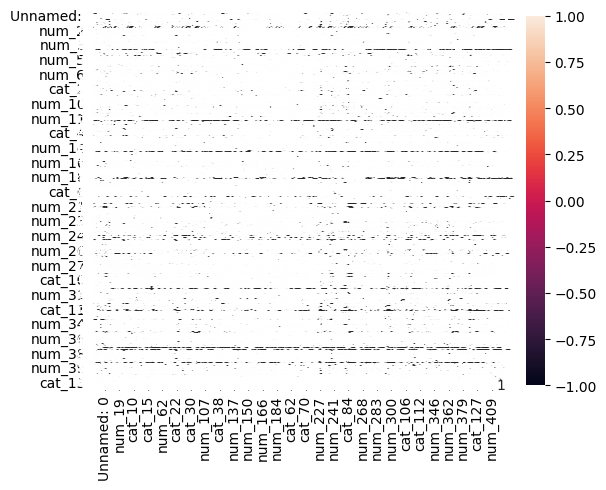

In [27]:
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True) # hard to read due to big amount of columns
plt.show()


In [31]:
print(len(df.loc[:,abs(corr_matrix.loc["gb"])>0.03].columns))
print(df.loc[:,abs(corr_matrix.loc["gb"])>0.03])

127
        num_4  num_7  cat_2  cat_3  num_26   num_27    num_28      num_32  \
0      1303.0   43.0      1      1    60.0 -10446.6   559.600  7768369.20   
1       565.0   19.0      1      1    12.0   -986.3    25.000    41999.36   
2      2294.0   76.0      2      2    15.0   -161.3    99.800   112589.52   
3      1236.0   41.0      1      1    41.0   -755.9   143.100    48983.65   
4      1340.0   45.0      1      1    64.0   1335.0    28.000   779486.22   
...       ...    ...    ...    ...     ...      ...       ...         ...   
26819   108.0    4.0      1      1    15.0   -186.4    96.425    36157.12   
26820  2149.0   72.0      1      1     5.0   -340.7  -199.101    24076.08   
26821  2215.0   74.0      2      1   112.0  23954.0   609.140  1350208.71   
26822   135.0    4.0      1      2    16.0 -14274.2    16.800  3083510.36   
26823    44.0    1.0      2      1    37.0  -9076.6  1706.600   184601.81   

       num_34  num_40  ...  num_390  num_391    num_395  num_399  num_4

That seems better! Lets Deal with NaN values and later on use Dimensionality Reduction, Feature selection and Regularization

### 2.1 Data Exploration

First let's analyze categorical features. Maybe we would find a way to encode them or find hidden patterns.
<br>
<br>Extracting categorical features:

In [45]:
categorical = []
for column in df.columns:
    if column.find("cat")!=-1:
        categorical.append(column)
    df_categorical = df[categorical]
        

Descriptive Statistics

Max variance: 108034.93383735517
Min variance: 0.0001863724415168713
Max max-value: 1461
Min max-value: 2
Max min-value: 1
Min min-value: 1
Max mean: 384.58854011333136
Min mean: 1.0001864002385923
Max median: 316.0
Min median: 1.0


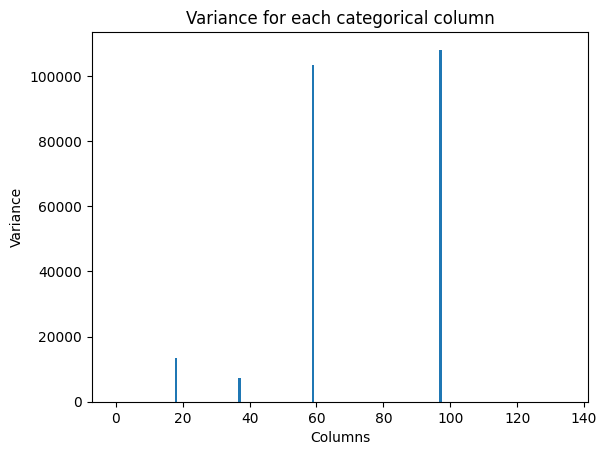

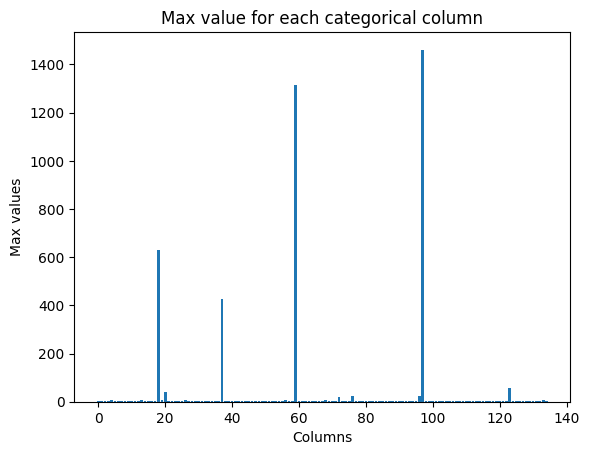

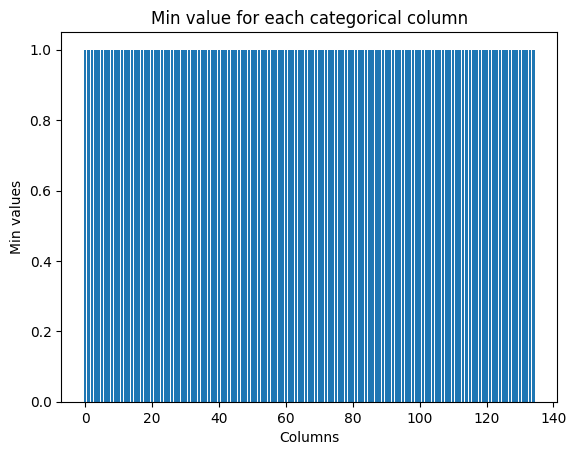

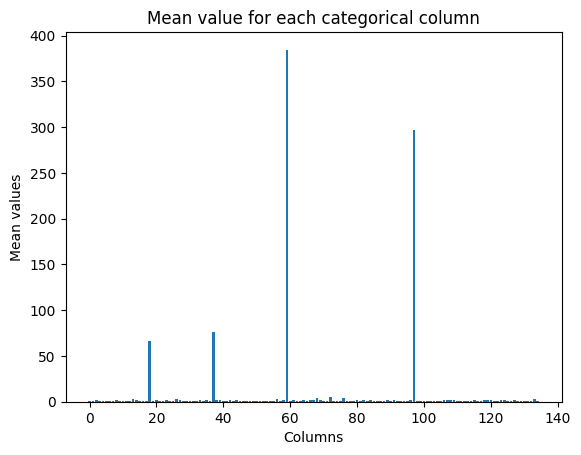

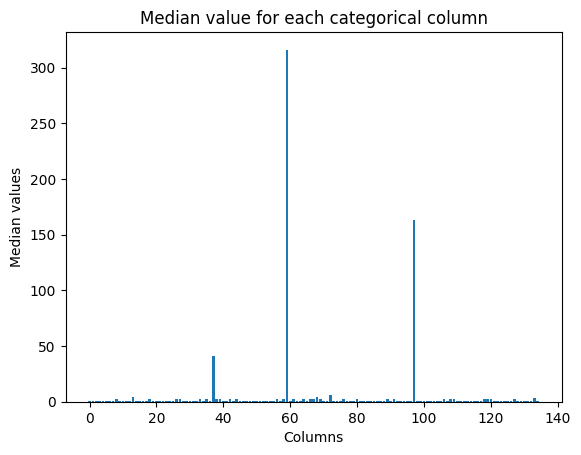

In [46]:
plt.figure(1)
 
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each categorical column")
print("Max variance: " + str(max(df_categorical.var())))
print("Min variance: " + str(min(df_categorical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each categorical column")
print("Max max-value: " + str(max(df_categorical.max())))
print("Min max-value: " + str(min(df_categorical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each categorical column")
print("Max min-value: " + str(max(df_categorical.min())))
print("Min min-value: " + str(min(df_categorical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each categorical column")
print("Max mean: " + str(max(df_categorical.mean())))
print("Min mean: " + str(min(df_categorical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each categorical column")
print("Max median: " + str(max(df_categorical.median())))
print("Min median: " + str(min(df_categorical.median())))

plt.show()


Some of the categorical features have way too more classes, on the other hand, most of the features has maximum 10 different classes and the most popular are the first ones (median of all median proves this)

In [47]:
print(df_categorical.median().median())

1.0


As we can see, the median of all medians is 1. <br>
Most of the categorical values equal to 1, avarage, median is near 1 and variance is around 0.<br>
Let's analyse the distribution for some of the features

Lets display distribution of features with high variance and max values

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

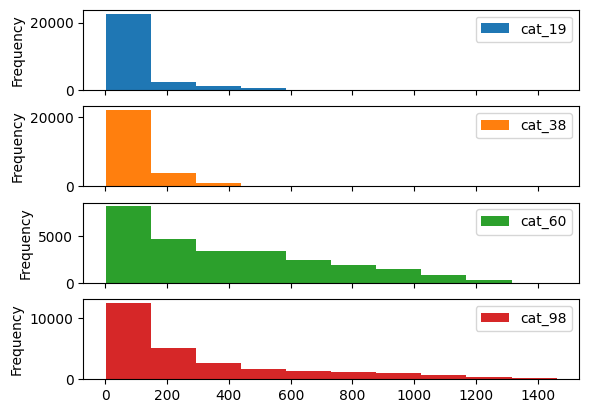

In [56]:
df_categorical.loc[:,df_categorical.var()>100].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

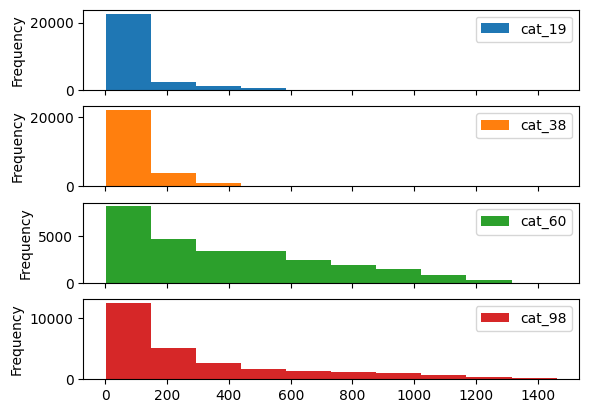

In [55]:
df_categorical.loc[:,df_categorical.max()>100].plot(kind='hist',subplots=True)

Now display distribution of features with low variance and max values

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

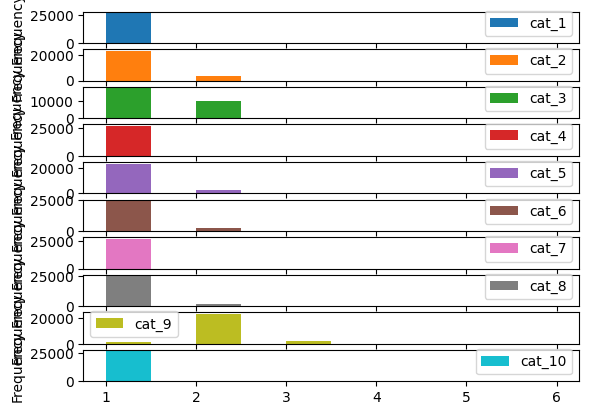

In [64]:
df_categorical.loc[:,df_categorical.var()<10].iloc[:, :10].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

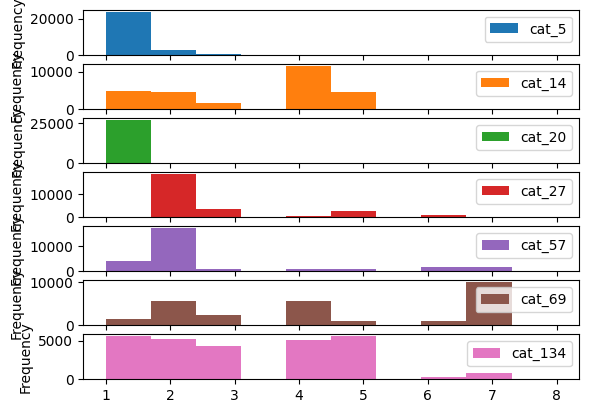

In [72]:
df_categorical.loc[:,(df_categorical.max() > 5) & (df_categorical.max() < 10)].iloc[:, :20].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

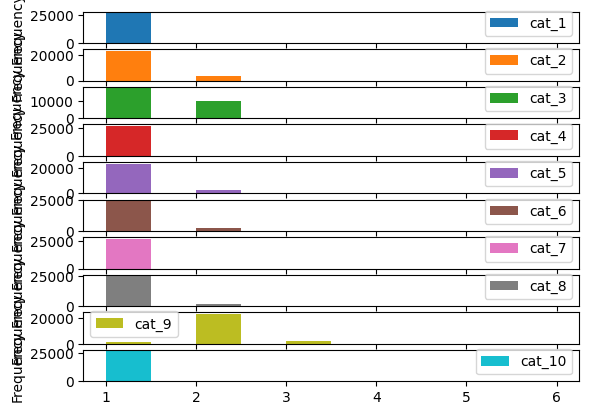

In [73]:
df_categorical.loc[:,df_categorical.max() < 15].iloc[:, :10].plot(kind='hist',subplots=True)

Future: do the same thing for numberic data and make conclusions for the NaN replacement. Goal: do at least correlation matrix.

In [74]:
numerical = []
for column in df.columns:
    if column.find("cat")==-1:
        numerical.append(column)
    df_numerical = df[numerical]
        

Max variance: 1.9592525971408014e+23
Min variance: 0.0
Max max-value: 35664478500000.0
Min max-value: -8561.0
Max min-value: 15514.0
Min min-value: -1578869000000.0
Max mean: 10419769119.9876
Min mean: -31978260.690276172
Max median: 44050000.0
Min median: -352634.25


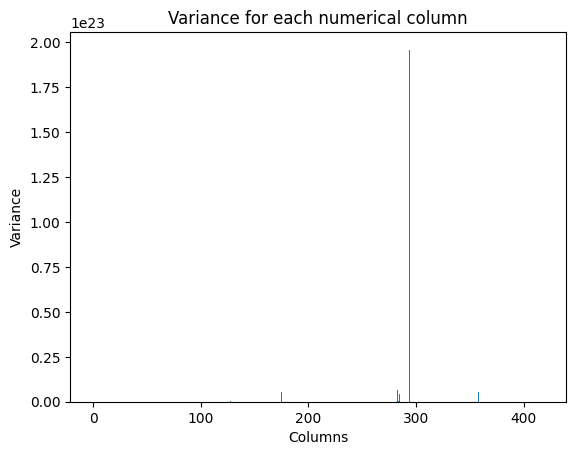

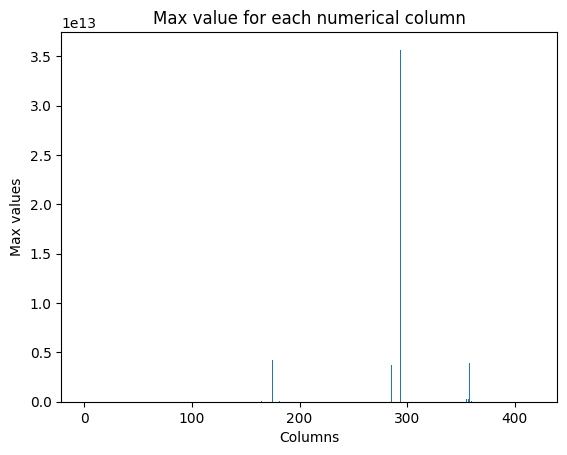

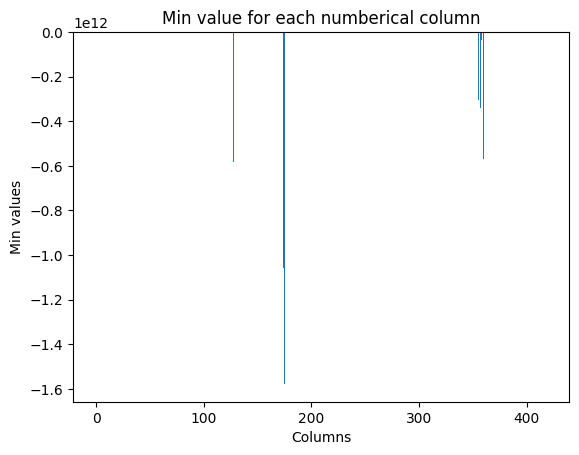

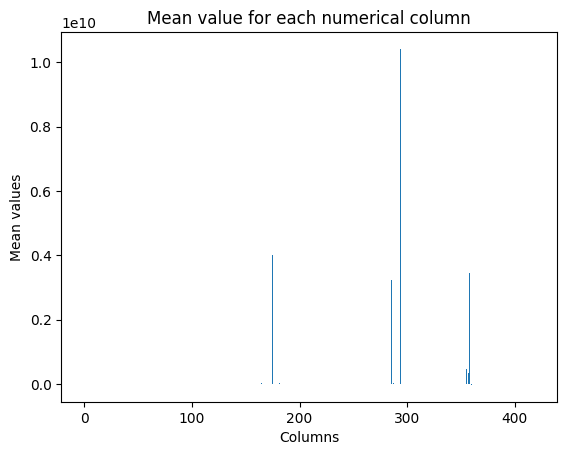

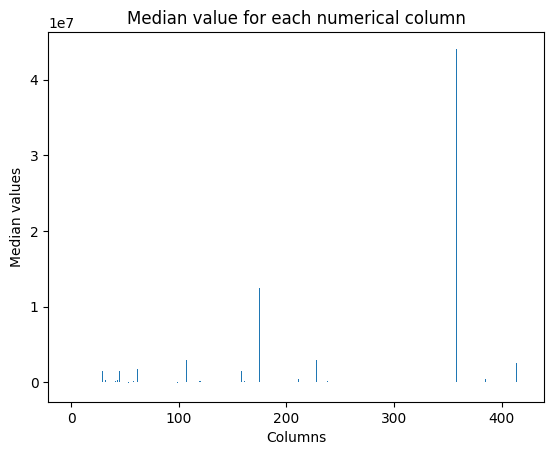

In [75]:
plt.figure(1)
 
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each numerical column")
print("Max variance: " + str(max(df_numerical.var())))
print("Min variance: " + str(min(df_numerical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each numerical column")
print("Max max-value: " + str(max(df_numerical.max())))
print("Min max-value: " + str(min(df_numerical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each numberical column")
print("Max min-value: " + str(max(df_numerical.min())))
print("Min min-value: " + str(min(df_numerical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each numerical column")
print("Max mean: " + str(max(df_numerical.mean())))
print("Min mean: " + str(min(df_numerical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each numerical column")
print("Max median: " + str(max(df_numerical.median())))
print("Min median: " + str(min(df_numerical.median())))

plt.show()


In [78]:
print(df_numerical.median().median())

75.0


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

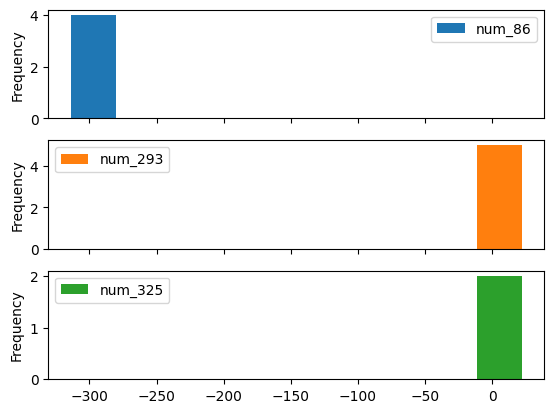

In [82]:
df_numerical.loc[:,df_numerical.var()==0].iloc[:, :10].plot(kind='hist',subplots=True)

In [125]:
# nan_columns = []
# for column in df.columns:
#     if (df[column].isna().sum())*100/len(df[column]) >=80:
#         nan_columns.append(column)

# Lets see if all columns that have 80% NaN values somehow corellates to result
for column in nan_columns:
    print(str(len(df[column])-df[column].isna().sum()) + " " + str(sum(df[df[column].notna()]["gb"]))+ " correlation: "+str(abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])))

#After taking into consideration the data above, I have decided to drop all the columns that have more than 80% NaN values and if they have less than 10 "1" in the target column when not NaN value.
# for column in nan_columns:
#     if column in data.columns:
#         if (sum(df[df[column].notna()]["gb"]))<10:
#             print(column + " dropped")
#             data.drop(column, axis=1)
    

#print(len(df_numerical["num_86"]))
    
#print(df_numerical[df_numerical['num_86'].notna()])

63 0 correlation: nan
36 0 correlation: nan
535 0 correlation: nan
445 0 correlation: nan
62 0 correlation: nan
1 0 correlation: nan
0 0 correlation: nan
1 0 correlation: nan
799 78 correlation: 0.025660684954407487
2459 18 correlation: 0.01619300644891149
4690 68 correlation: 0.018083236534990024
2395 18 correlation: 0.017565864504016128
4643 62 correlation: 0.019015246943055494
2527 104 correlation: 0.08489204061811993
12 0 correlation: nan
232 4 correlation: 0.043175098212029354
720 7 correlation: 0.023442025417999533
8 0 correlation: nan
177 0 correlation: nan
93 0 correlation: nan
258 8 correlation: 0.012800746626957678
447 14 correlation: 0.03045821033735875
1705 6 correlation: 0.002198053105980472
1140 6 correlation: 0.02195028787731583
0 0 correlation: nan
445 0 correlation: nan
4208 107 correlation: 0.013764095135697443
466 7 correlation: 0.010284431637767724
4 0 correlation: nan
151 4 correlation: 0.04257946503632065
149 0 correlation: nan
110 0 correlation: nan
2983 74 corre